<a href="https://colab.research.google.com/github/digichriz/EMBA2026-Lab/blob/main/exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My awesome LLM-Application **Reputatio AI**

###Setup
First, make the necessary imports.
Note that further imports may have to be made in addition to the ones below, if your application uses additional fetures such as loaders and tools. You can find the code for these imports in the respective sections of the tutorial notebooks.

In [5]:
!pip install -q langchain langchain-community langchain-core langchain-openai langchain-huggingface langchain-google-genai reportlab
from google.colab import userdata
from langchain_core.runnables import RunnableSequence, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import pprint
import getpass
import requests
import IPython.display as ipd
from PIL import Image as PILImage
import urllib.request
import re
import matplotlib.pyplot as plt
import base64
from openai import OpenAI
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak
from reportlab.platypus import Image as RLImage
from IPython.display import Image as IPyImage, display, Markdown
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.platypus.flowables import HRFlowable
from datetime import datetime
import base64
from openai import OpenAI
from IPython.display import Image, display


Then, assign the API keys to be able to use OpenAI, Google Serper, Huggingface, etc.

When working with sensitive information like API keys or passwords in Google Colab, it's crucial to handle data securely. As you learnt in the tutorial session, two common approaches for this are using **Colab's Secrets Manager**, which stores and retrieves secrets without exposing them in the notebook, and `getpass`, a Python function that securely prompts users to input secrets during runtime without showing them. Both methods help ensure your sensitive data remains protected.

In [6]:
# **********************************************************************************************
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  *
# *                                                                                            *
# *                                      R E P U T A T I O   A I                                 *
# *                                                                                            *
# *                     Multi-AI perception analysis enriched with public web data              *
# *                                                                                            *
# *                                                                                            *
# *   What this notebook does                                                                   *
# *   ----------------------------------------------------------------------------------------  *
# *   • Builds a fact sheet from publicly available online information                          *
# *   • Analyzes how different AI models perceive the same entity                               *
# *   • Create a Matplot diagram from the sentiment ranking                                     *
# *   • Enhances the diagram with imgAI                                                        *
# *   • Provides a PDF report                                                                  *
# *   • Workflow includes defensive error handling with try/except blocks                      *
# *                                                                                            *
# *   Built & maintained by                                                                     *
# *   ----------------------------------------------------------------------------------------  *
# *   Christian Schmid                                                                          *
# *                                                                                            *
# *                                                                                            *
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★ *
# *                                                                                            *
# **********************************************************************************************



#API Key Imports
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["OPENROUTER_API_KEY"] = userdata.get("OPENROUTER_API_KEY")


# G L O B A L  V A R S
search = GoogleSerperAPIWrapper()
client = OpenAI()

llmOpenAI = ChatOpenAI(model="gpt-5-mini")
llmGemini = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

#Openrouter API for free access on a deepseek Model as our 3rd LLM
llmDeepSeek = ChatOpenAI(
    model="deepseek/deepseek-v3.2",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
)

#dict for storing 1:n LLMs
llms = {
    "openai": llmOpenAI,
    "gemini": llmGemini,
    "deepseek": llmDeepSeek
}

####User Input
The user is expected to provide a company name via the chat interface. As this interface is not available in the current notebook, an example company name is stored in a variable instead.

This value can be adjusted either directly here or at the very end of the notebook, where the complete processing chain is invoked.

In [7]:
user_input = "Georg Fischer AG"

###Prompt Templates

In [8]:

#Template to feed the different AI models
analyze_prompt_template = PromptTemplate(
    input_variables=["company"],
    template = ("""Based on the company name provided: {company}, generate a concise company profile and assessment.
                Include:
                - A brief description of what the company does
                - Its primary industry and general market positioning
                - Perceived strengths and weaknesses
                - Overall reputation and maturity level

                Rules:
                - Use only widely known, high-level information
                - Do not speculate or invent facts
                - Explicitly state uncertainty where information is unclear or unavailable
                - Use a neutral, analytical tone
                - Maximum length: 150–200 words
                - Return a result, and do not dodge the task"""
               )
)

#Template for one of the AI (in my case openAI) to analyze the sentiment of the results from the AI models
sentiment_prompt_template = PromptTemplate(
    input_variables=["company_analysis_sentiment"],
    template = ("""You are analyzing the output of an AI-generated company assessment.
                Input text:
                {company_analysis_sentiment}

                Your task:
                - Determine whether the overall sentiment of the text is predominantly positive, neutral, or negative
                - Explain briefly why this sentiment classification applies, referring only to the content of the text
                - Provide a sentiment rating on a scale from 1 to 5, where:
                  1 = very negative
                  2 = mostly negative
                  3 = neutral or balanced
                  4 = mostly positive
                  5 = very positive

                Rules:
                - Do not introduce new information or external knowledge
                - Base your evaluation strictly on tone, wording, and emphasis in the provided text
                - If the sentiment is mixed, explain which aspects pull it in each direction
                - Keep the total response under 120 words
                - Use a neutral, analytical tone
                - Return a result, and do not dodge the task
                - Return your result ONLY in exactly this format (3 lines, nothing else):
                  Sentiment: <positive|neutral|negative>
                  Rating: <1|2|3|4|5>
                  Rationale: <sentence>
                - No additional text, no blank lines, no punctuation after the numbers
                - Rating must be a single integer 1–5 (not "4/5", not "3 (neutral)", not "4/5 (mostly positive)")
                - Each field MUST start on a new line

                Example output:
                  Sentiment: neutral
                  Rating: 3
                  Rationale: The text is balanced and emphasizes uncertainty more than praise or criticism."""
               )
)


#Template for enhancing the diagram
image_pimp_prompt_template = PromptTemplate(
    input_variables = [],
    template = ("""You are a professional infographic designer.

              You are given an existing bar chart image that visualizes sentiment ratings.
              Your task is to RESTYLE the image for visual quality only.

              STRICT RULES (must be followed exactly):
              - Do NOT change bar heights, proportions, or positions
              - Do NOT change numeric values, labels, or axis scales
              - Do NOT add or remove data
              - Do NOT reinterpret the chart or redraw it differently
              - Preserve the exact structure and meaning of the original chart

              ALLOWED ENHANCEMENTS:
              - Improve color palette (professional, modern)
              - Add subtle gradients or soft shadows
              - Improve typography clarity and alignment
              - Slightly round bar edges
              - Clean, neutral background
              - Improve spacing and visual balance

              STYLE:
              - Clean corporate infographic
              - Flat design with subtle depth
              - High contrast but restrained colors
              - Suitable for an executive PDF report
              - No decorative icons or illustrations

              OUTPUT:
              - The background should be dark grey
              - Each bar is glowing and has a different color
              - A visually enhanced version of the same chart
              - Data accuracy must be preserved exactly"""
            )
)

#Template for PDF report creation
pdfreport_prompt_template = PromptTemplate(
    input_variables=[
      "company_results",
      "sentiment_results",
      "sentiment_diagram"
      ],
    template = ("""You are creating a structured analytical report intended for export as a PDF.

                Input data:
                1) Company analysis results from multiple AI models:
                {company_results}

                2) Sentiment analysis of these results:
                {sentiment_results}

                3) Sentiment comparison diagram (Mermaid):
                {sentiment_diagram}

                Your task:
                Create a well-structured report with the following sections:

                1. Executive Summary
                  - High-level overview of the company
                  - Key themes consistently mentioned across AI models

                2. Company Analysis (AI Model Perspectives)
                  - Summarize the main observations from each model
                  - Highlight common strengths, weaknesses, and uncertainties
                  - Keep the tone neutral and analytical

                3. Sentiment Analysis
                  - Explain how each model's output was evaluated
                  - Compare sentiment classifications and ratings
                  - Briefly interpret similarities and differences

                4. Sentiment Comparison Visualization
                  - Introduce the diagram
                  - Explain what it shows and how to read it
                  - Embed the provided diagram as-is

                5. Overall Conclusion
                  - Summarize how the company is perceived across models
                  - Comment on overall sentiment balance and confidence level

                Formatting rules:
                - Use clear headings and subheadings
                - Write in professional report language
                - Avoid speculation or new information
                - Ensure the text is suitable for direct PDF export
                - Do not reference prompts or AI instructions"""
               )
)

###Websearch Chain

In [9]:
#Recent web search for the company using Google Serper - used as additional input for LLM
def serper_company_search(company_name, num_results=5):
    url = "https://google.serper.dev/search"
    headers = {
        "X-API-KEY": os.environ.get("SERPER_API_KEY"),
        "Content-Type": "application/json",
    }
    payload = {
        "q": company_name,
        "num": num_results,
    }

    try:
        response = requests.post(url, headers=headers, json=payload, timeout=10)
        response.raise_for_status()
        data = response.json()

        snippets = []
        for item in data.get("organic", []):
            title = item.get("title", "")
            snippet = item.get("snippet", "")
            if snippet:
                snippets.append(f"- {title}: {snippet}")

        if not snippets:
            return "No relevant web information found."

        return "Recent publicly available web context:\n" + "\n".join(snippets[:num_results])

    except Exception as e:
        return f"Web search unavailable due to error: {e}"



#Calling the function + show results in markdown (optional / just a quick control/checkpoint)
web_context = serper_company_search(user_input)
display(Markdown(f"### Serper Web Search Result\n\n{web_context}"))


### Serper Web Search Result

Recent publicly available web context:
- Georg Fischer: Georg Fischer: worldwide preferred partner for the safe transport of liquids and gases, vehicle weight reduction and high-precision manufacturing ...
- Georg Fischer (company): Founded in 1802, the corporation is headquartered in Switzerland and is present in 45 countries, with 187 companies, 76 of them production facilities.
- Georg Fischer AG (GF.SW) Stock Price, News, Quote & ...: Georg Fischer AG engages in the provision of piping systems, and casting and machining solutions in Europe, the Americas, Asia, and internationally.
- About Us - Georg Fischer Ltd: Headquartered in Switzerland, GF employs about 15'700 professionals and is present in 46 countries. GF generated sales of CHF 4'776 million in 2024. GF is ...
- GF Piping Systems: Please confirm your country and language. Country & Language. United States | English. Go to Website Change Country.

###Analyze Company Chain




In [10]:
#Function to invoke the different LLMs to gather info about the company, include search results as additional context
def analyze_company(llms, user_input):

    results = {}

    #Invoke the search
    web_context = serper_company_search(user_input)

    #Loop through all LLMs and store their response in a dictionary
    for name, llm in llms.items():
      try:
        prompt = analyze_prompt_template.format(company=user_input, web_context=web_context)
        response = llm.invoke(prompt)
        content = response.content if hasattr(response, "content") else str(response)
        results[name] = content

      except Exception as e:
          results[name] = f"Analysis failed for model '{name}': {e}"
          print(f"[WARN] {name} analysis failed:", e)

    return results


#Call the function and store the output in results
results = analyze_company(llms, user_input)

#Show the results in markdown (optional / just for a quick control/checkpoint)
for name, text in results.items():
    display(Markdown(f"## {name.upper()} perception"))
    display(Markdown(text))


## OPENAI perception

Georg Fischer AG (GF) is a Swiss industrial group, founded in 1802 and headquartered in Schaffhausen. It designs and manufactures components and systems for industrial applications, operated through major businesses known publicly as Piping Systems, Casting Solutions, and Machining (machine tools). GF serves B2B markets including water and gas distribution, automotive and industrial casting customers, and precision machining.

Primary industry and positioning: GF is a global industrial-manufacturing and engineering supplier with a diversified product portfolio across piping, casting and machine-tool segments. It is publicly listed on the SIX Swiss Exchange and is positioned as an established supplier to other industrial companies rather than an end-consumer brand.

Perceived strengths: long history and institutional maturity; diversified industrial divisions; engineering and manufacturing expertise; global footprint and established customer relationships. Perceived weaknesses: exposure to cyclical capital-goods and industrial demand; operational complexity across multiple business lines. Specific financial metrics, current market share figures and recent strategic priorities are not provided here and therefore uncertain. 

Overall reputation and maturity: widely regarded as a mature, long-standing Swiss industrial firm with a stable, B2B-focused reputation in its sectors.

## GEMINI perception

**Company Profile & Assessment: Georg Fischer AG**

**Description & Industry:**
Based solely on the name "Georg Fischer AG," the company's specific products, services, and primary industry are not directly discernible. The "AG" designation (Aktiengesellschaft) indicates a public limited company, commonly found in German-speaking regions (e.g., Switzerland, Germany). Historically, companies named after founders with this structure often operate in industrial, manufacturing, or engineering sectors, but this is an inference based on common corporate naming patterns, not direct information from the name itself.

**Strengths:**
The use of a founder's name combined with the "AG" structure often suggests a company with a long history, implying stability, established operations, and potentially a strong legacy or brand within its (unknown) field. This structure typically points to a mature organization with robust governance.

**Weaknesses:**
A non-descriptive name like "Georg Fischer AG" provides no immediate insight into the company's business activities. This lack of direct communication could be a minor challenge in marketing or when introducing the company to new, unfamiliar markets or stakeholders without prior context.

**Reputation & Maturity:**
The combination of a personal name and the "AG" legal form strongly suggests a highly mature and established company. Its reputation is likely built on a long operational history, implying reliability, experience, and a traditional approach within its specific industry.

## DEEPSEEK perception

**Company Profile and Assessment: Georg Fischer AG**

**Description:** Georg Fischer AG (GF) is a Swiss industrial manufacturer. Its operations are divided into three core divisions: GF Piping Systems (plastic and metal piping systems), GF Casting Solutions (lightweight vehicle components and iron castings), and GF Machining Solutions (precision machining equipment). The company is known for its specialization in flow technology, casting, and manufacturing systems.

**Industry and Positioning:** It is a global industrial manufacturing group, positioned as a niche specialist in its core segments. GF holds strong market positions, particularly in high-precision piping systems for process engineering and in components for the automotive industry.

**Strengths and Weaknesses:** Perceived strengths include a long industrial heritage (founded 1802), engineering expertise, and a diversified portfolio across stable industrial sectors. A potential weakness is its cyclical exposure to key end-markets like automotive and construction, though this is mitigated by diversification. The relative performance and market share of its three divisions can vary.

**Reputation and Maturity:** The company has an established reputation for precision engineering and quality. It is considered a mature and stable industrial player with a solid financial history.

###Sentiment Chain

In [12]:
#Function to analyze the sentiment of the provided results
def analyze_sentiment(results, llm):

    sentiment_results = {}

    for model_name, company_text in results.items():
      try:
        prompt = sentiment_prompt_template.format(
            company_analysis_sentiment=company_text
        )

        response = llm.invoke(prompt)
        content = response.content if hasattr(response, "content") else str(response)
        sentiment_results[model_name] = content

      except Exception as e:
          sentiment_results[model_name] = (
              "Sentiment: unknown\n"
              "Rating: 3\n"
              f"Rationale: Sentiment evaluation failed due to error: {e}"
            )
          print(f"[WARN] Sentiment failed for {model_name}:", e)

    return sentiment_results

#Call the function and store the output in sentiments (only 1 LLM needed - I chose openAI)
sentiments = analyze_sentiment(results, llmOpenAI)


#Show the results in markdown (optional / just for a quick control/checkpoint)
for model_name, sentiment_text in sentiments.items():
    display(
        Markdown(
            f"## {model_name.upper()} – Sentiment Evaluation\n\n{sentiment_text}"
        )
    )


## OPENAI – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The tone is mostly positive, emphasizing long history, diversified businesses, engineering expertise and global customer relationships, while also noting cyclical demand exposure and operational complexity that temper the assessment.

## GEMINI – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The text emphasizes maturity, stability, legacy, and strong governance as strengths while noting only a minor weakness (a non-descriptive name), producing an overall mostly positive tone

## DEEPSEEK – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The text emphasizes strengths—market positions, engineering expertise, reputation and stability—while only noting a mitigated cyclical exposure, producing a mostly positive tone.

Diagram Chain

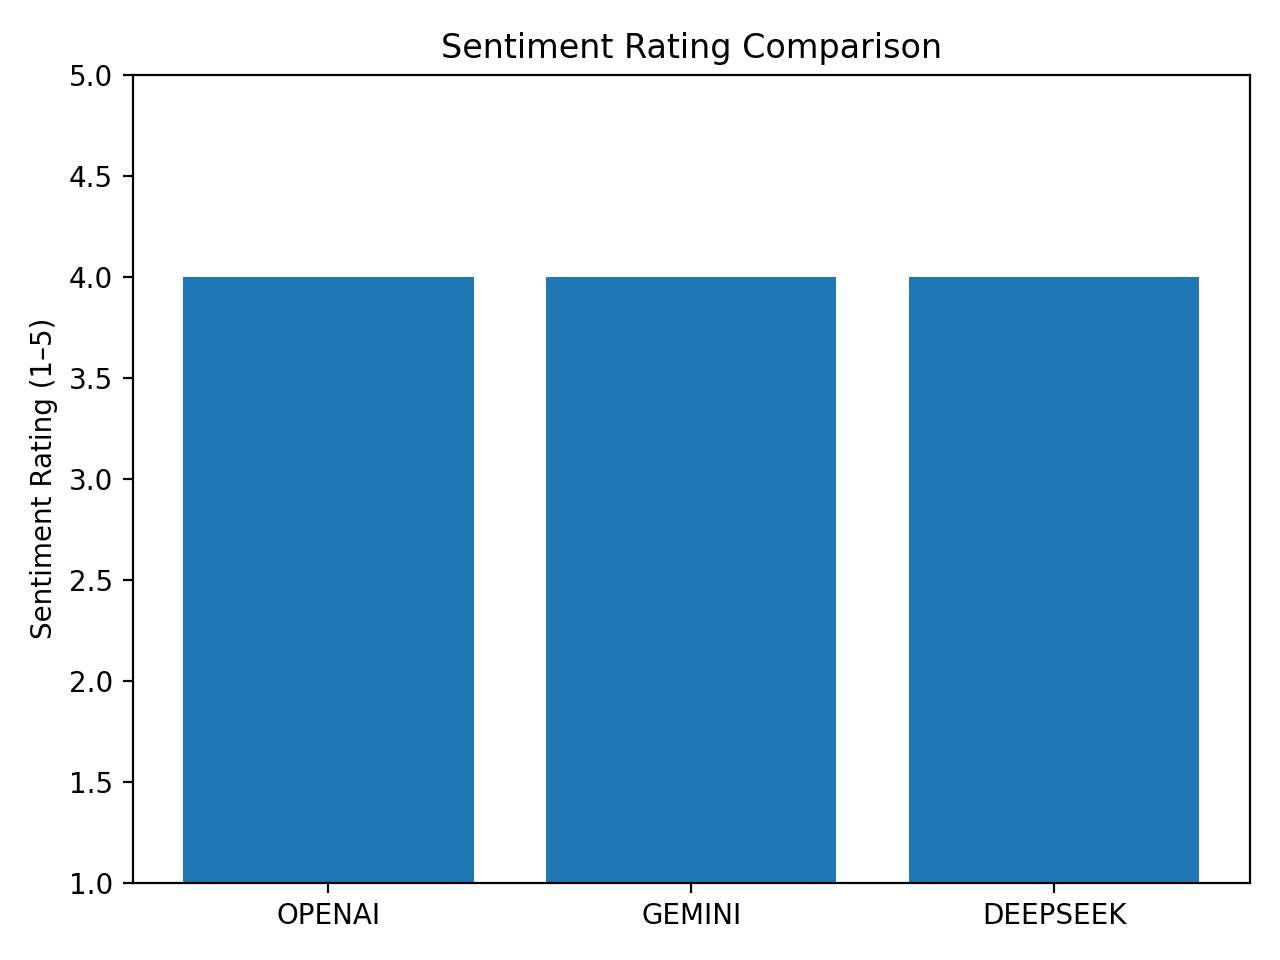

Saved: sentiment_comparison.png


In [14]:
#Function to create a PNG bar chart based on the sentiment rating with Python matplotlib library
def save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png", title="Sentiment Rating Comparison"):

    models = []
    ratings = []

    for model_name, text in sentiments.items():
      try:
        m = re.search(r"Rating:\s*([1-5])\b", str(text))
        if not m:
            raise ValueError(f"Could not find a valid 'Rating: 1-5' for model '{model_name}'. Text was:\n{text}")
        models.append(model_name.upper())
        ratings.append(int(m.group(1)))

      except Exception as e:
        print(f"[WARN] Skipping model '{model_name}' in chart:", e)


    plt.figure()
    plt.bar(models, ratings)
    plt.ylim(1, 5)
    plt.ylabel("Sentiment Rating (1–5)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

    display(IPyImage(filename=filename))
    return filename

png_path = save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png")
print("Saved:", png_path)



DiagramPimp Chain

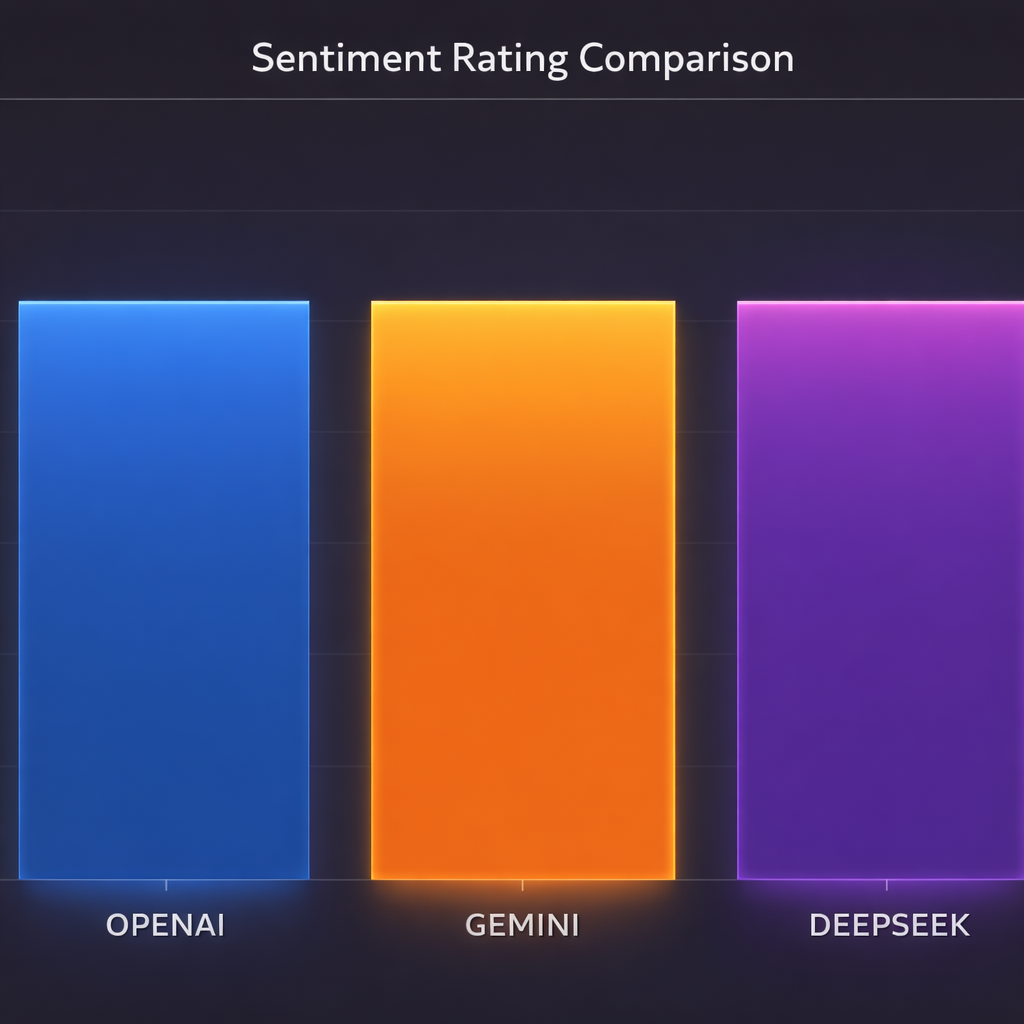

Saved: sentiment_comparison_pimped.png


In [16]:

#Function to enhance the matplot diagram with openAI img
def pimp_sentiment_chart_image_api(
    input_png_path: str,
    output_png_path: str = "sentiment_comparison_pimped.png",
    model: str = "gpt-image-1.5",
):
  try:
    # Style from prompt template:
    prompt_text = image_pimp_prompt_template.format()

    # Images API
    with open(input_png_path, "rb") as img_file:
        result = client.images.edit(
            model=model,
            image=img_file,
            prompt=prompt_text,
            output_format="png",
        )

    # GPT Image modell base64
    image_bytes = base64.b64decode(result.data[0].b64_json)
    with open(output_png_path, "wb") as f:
        f.write(image_bytes)

    display(IPyImage(filename=output_png_path))

  except Exception as e:
     print("[ERROR] Image enhancement failed:", e)
     print("→ Falling back to original chart.")

  return output_png_path


# function call test - optional just to see it here:
pimped_chart = pimp_sentiment_chart_image_api(
    input_png_path="sentiment_comparison.png",
    output_png_path="sentiment_comparison_pimped.png"
)
print("Saved:", pimped_chart)



###PDF Report

In [17]:

def export_company_report_pdf(company_name, results, sentiments, chart_png_path,
                              output_pdf_path="company_report.pdf"):

    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        "Title",
        parent=styles["Title"],
        fontSize=20,
        leading=24,
        spaceAfter=12
    )
    h1 = ParagraphStyle(
        "H1",
        parent=styles["Heading1"],
        fontSize=14,
        leading=18,
        spaceBefore=12,
        spaceAfter=8
    )
    h2 = ParagraphStyle(
        "H2",
        parent=styles["Heading2"],
        fontSize=12,
        leading=16,
        spaceBefore=10,
        spaceAfter=6
    )
    body = ParagraphStyle(
        "Body",
        parent=styles["BodyText"],
        fontSize=10.5,
        leading=14,
        spaceAfter=8
    )
    mono = ParagraphStyle(
        "Mono",
        parent=styles["BodyText"],
        fontName="Courier",
        fontSize=9.5,
        leading=12,
        textColor=colors.black,
        spaceAfter=8
    )

    doc = SimpleDocTemplate(
        output_pdf_path,
        pagesize=A4,
        leftMargin=2*cm,
        rightMargin=2*cm,
        topMargin=2*cm,
        bottomMargin=2*cm
    )

    story = []

    # ---- Cover / Header
    story.append(Paragraph("Company Perception Report", title_style))
    story.append(Paragraph(f"<b>Company:</b> {company_name}", body))
    story.append(Paragraph(f"<b>Generated:</b> {datetime.now().strftime('%Y-%m-%d %H:%M')}", body))
    story.append(Spacer(1, 8))
    story.append(HRFlowable(width="100%", thickness=1, color=colors.grey))
    story.append(Spacer(1, 12))

    # ---- Section: Company analyses
    story.append(Paragraph("1. Company Analysis (Model Outputs)", h1))
    story.append(Paragraph(
        "Below are the raw company assessments produced by each model.", body
    ))

    for model_name, text in results.items():
        story.append(Paragraph(model_name.upper(), h2))
        # Keep formatting simple: convert newlines to <br/>
        safe_text = (text or "").replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
        safe_text = safe_text.replace("\n", "<br/>")
        story.append(Paragraph(safe_text, body))
        story.append(Spacer(1, 6))

    story.append(PageBreak())

    # ---- Section: Sentiment analyses
    story.append(Paragraph("2. Sentiment Evaluation (Single Evaluator Model)", h1))
    story.append(Paragraph(
        "Below are the sentiment classifications and ratings applied to each model output.",
        body
    ))

    for model_name, s_text in sentiments.items():
        story.append(Paragraph(model_name.upper(), h2))
        # sentiment outputs are short; mono looks nice and keeps line breaks
        s_safe = (s_text or "").replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
        story.append(Paragraph("<br/>".join(s_safe.splitlines()), mono))
        story.append(Spacer(1, 6))

    story.append(PageBreak())

    # ---- Section: Chart
    story.append(Paragraph("3. Sentiment Rating Comparison Chart", h1))
    story.append(Paragraph(
        "The chart below visualizes the sentiment ratings (1-5) across model outputs.",
        body
    ))

    if chart_png_path and os.path.exists(chart_png_path):
        img = RLImage(chart_png_path)

        page_width, page_height = A4

        # IMPORTANT: use the actual usable width (margins!) + add a small safety padding
        usable_width = page_width - doc.leftMargin - doc.rightMargin
        max_width = usable_width - 12   # <- 12 points safety buffer
        max_height = page_height * 0.4

        img_width = img.imageWidth
        img_height = img.imageHeight

        scale = min(max_width / img_width, max_height / img_height)

        img.drawWidth = img_width * scale
        img.drawHeight = img_height * scale
        img.hAlign = "CENTER"           # <- centers the image in the frame

        story.append(Spacer(1, 12))
        story.append(img)
    else:
        story.append(Paragraph(
            f"Chart image not found at: {chart_png_path}", body
        ))

    # Build PDF
    doc.build(story)
    return output_pdf_path


#Call the function and generate the pdf report
pdf_path = export_company_report_pdf(
    company_name=user_input,
    results=results,
    sentiments=sentiments,
    chart_png_path="sentiment_comparison_pimped.png",
    output_pdf_path="company_report.pdf"
)

print("PDF saved to:", pdf_path)


PDF saved to: company_report.pdf


###Final Sequential Chain for quick repetition

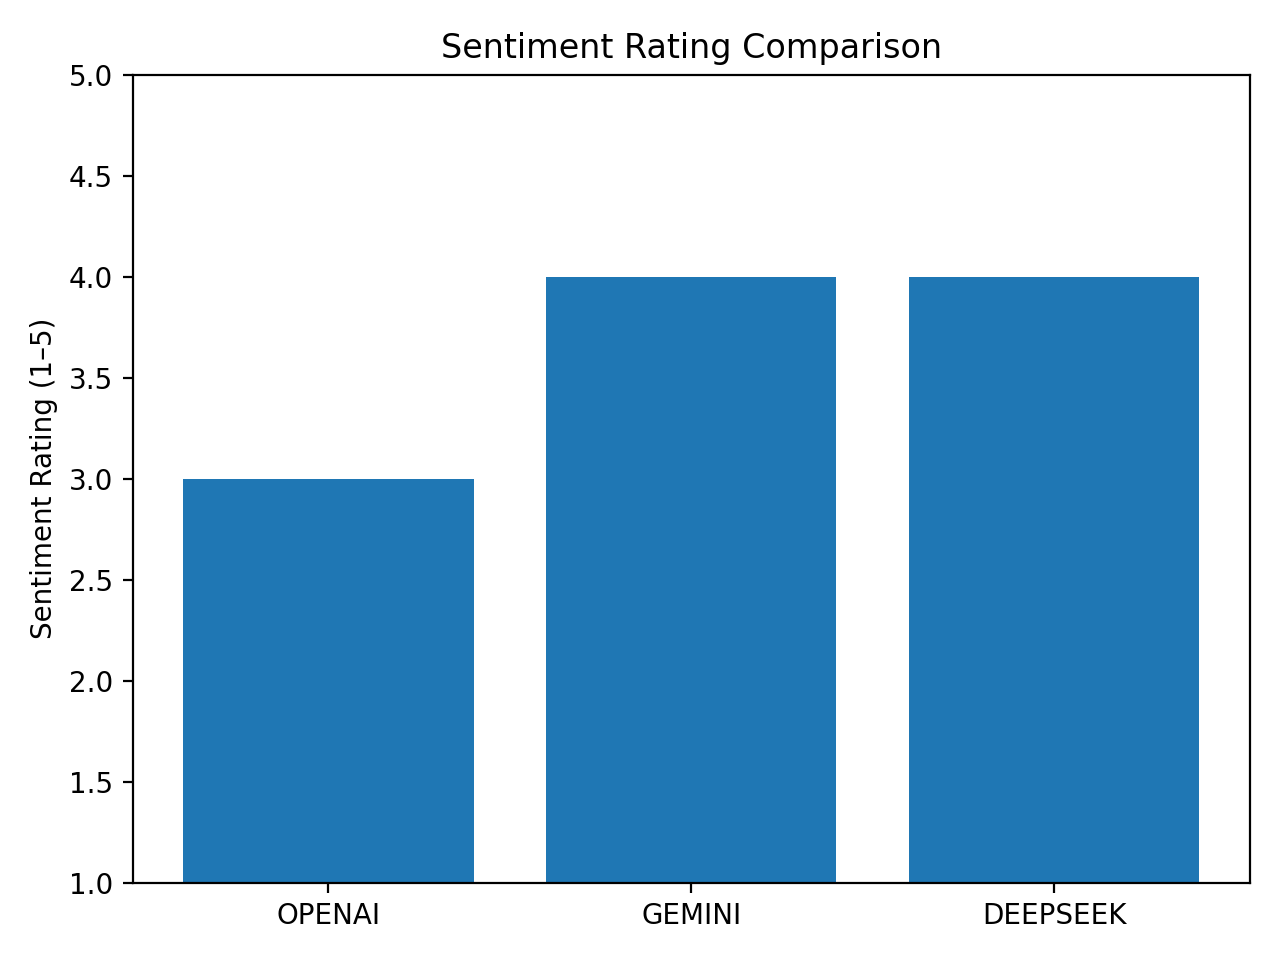

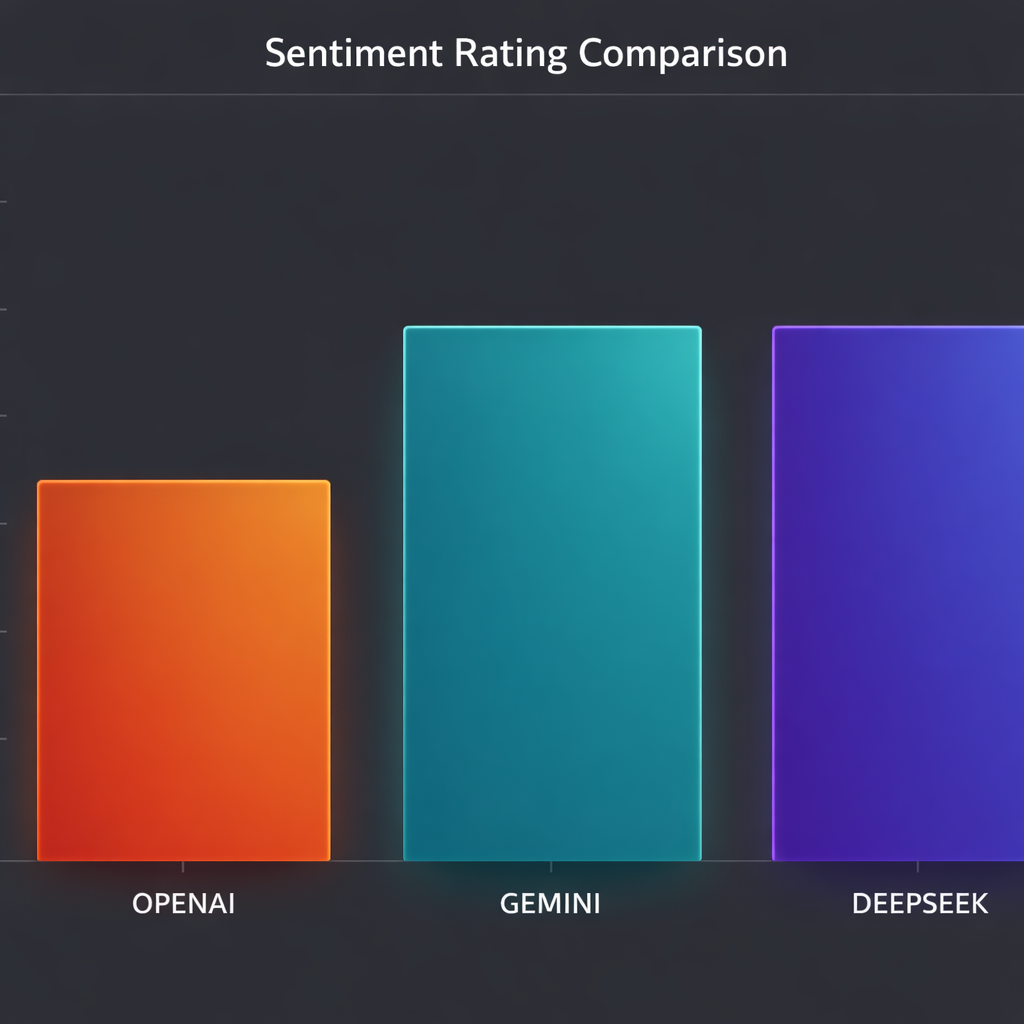

PDF: company_report_Amazon.pdf
Pimped chart: sentiment_comparison_Amazon_pimped.png


In [19]:
#Lets use another example user_input
user_input = "Amazon"


web_search_step = RunnableLambda(
    lambda x: {**x, "web_context": serper_company_search(x["company"])}
)

analysis_step = RunnableLambda(
    lambda x: {
        **x,
        "results": analyze_company(llms, x["company"])
    }
)

sentiment_step = RunnableLambda(
    lambda x: {
        **x,
        "sentiments": analyze_sentiment(x["results"], llmOpenAI)
    }
)

chart_step = RunnableLambda(
    lambda x: {
        **x,
        "chart_png_path": save_sentiment_chart_png(
            x["sentiments"],
            filename=f"sentiment_comparison_{x['company'].replace(' ','_')}.png"
        )
    }
)

pimp_step = RunnableLambda(
    lambda x: {
        **x,
        "pimped_chart_png_path": pimp_sentiment_chart_image_api(
            input_png_path=x["chart_png_path"],
            output_png_path=f"sentiment_comparison_{x['company'].replace(' ','_')}_pimped.png"
        )
    }
)


pdf_step = RunnableLambda(
    lambda x: {
        **x,
        "pdf_path": export_company_report_pdf(
            company_name=x["company"],
            results=x["results"],
            sentiments=x["sentiments"],
            chart_png_path=x["pimped_chart_png_path"],
            output_pdf_path=f"company_report_{x['company'].replace(' ','_')}.pdf"
        )
    }
)

pipeline = RunnableSequence(
    web_search_step,
    analysis_step,
    sentiment_step,
    chart_step,
    pimp_step,
    pdf_step
)

#This invokes our whole pipeline - pdf report with _company will be saved under files
out = pipeline.invoke({"company": user_input})

print("PDF:", out["pdf_path"])
print("Pimped chart:", out["pimped_chart_png_path"])
